In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


In [266]:
df =  pd.read_csv('ReadyData/EURUSD_2020_2023_15M_READY.csv',index_col=0,parse_dates=True)

In [267]:
df

,open,high,low,close,volume,low_time,high_time
time,,,,,,,
2020-01-02 00:15:00,1.12073,1.12152,1.12073,1.12144,88,2020-01-02 00:15:00,2020-01-02 00:24:00
2020-01-02 00:30:00,1.12145,1.12157,1.12141,1.12151,53,2020-01-02 00:34:00,2020-01-02 00:44:00
2020-01-02 00:45:00,1.12156,1.12165,1.12142,1.12142,253,2020-01-02 00:59:00,2020-01-02 00:50:00
2020-01-02 01:00:00,1.12142,1.12216,1.12142,1.12201,252,2020-01-02 01:00:00,2020-01-02 01:03:00
2020-01-02 01:15:00,1.12201,1.12211,1.12195,1.12211,66,2020-01-02 01:17:00,2020-01-02 01:29:00
...,...,...,...,...,...,...,...
2023-12-20 11:45:00,1.09629,1.09655,1.09628,1.09644,684,2023-12-20 11:45:00,2023-12-20 11:49:00
2023-12-20 12:00:00,1.09642,1.09652,1.09591,1.09600,745,2023-12-20 12:09:00,2023-12-20 12:01:00
2023-12-20 12:15:00,1.09599,1.09624,1.09495,1.09518,818,2023-12-20 12:25:00,2023-12-20 12:17:00


In [268]:
df['change'] = df.close.pct_change()

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98992 entries, 2020-01-02 00:15:00 to 2023-12-20 12:45:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       98992 non-null  float64
 1   high       98992 non-null  float64
 2   low        98992 non-null  float64
 3   close      98992 non-null  float64
 4   volume     98992 non-null  int64  
 5   low_time   98989 non-null  object 
 6   high_time  98989 non-null  object 
 7   change     98991 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 6.8+ MB


In [270]:
def calculate_up_down(df):
    df['up'] = 0.0
    df['down'] = 0.0

    for i in range(1, len(df)):
        current_row = df.index[i]
        previous_row = df.index[i - 1]

        if df.at[current_row, 'change'] > 0:
            df.at[current_row, 'up'] = df.at[current_row, 'change'] + df.at[previous_row, 'up']
            df.at[current_row, 'down'] = 0
        elif df.at[current_row, 'change'] < 0:
            df.at[current_row, 'down'] = df.at[current_row, 'change'] + df.at[previous_row, 'down']
            df.at[current_row, 'up'] = 0
        else:
            df.at[current_row, 'up'] = 0 
            df.at[current_row, 'down'] = 0



In [272]:

def update_count_columns(df):
    df['count_up'] = 0
    df['count_down'] = 0

    for i in range(1, len(df)):
        cur_index = df.index[i]
        prev_index = df.index[i - 1]

        if df.at[prev_index, 'up'] == 0 and df.at[cur_index, 'up'] > 0:
            df.at[cur_index, 'count_up'] = df.at[prev_index, 'count_up'] + 1

        elif df.at[prev_index, 'up'] > 0 and df.at[cur_index, 'up'] > 0:
            df.at[cur_index, 'count_up'] = df.at[prev_index, 'count_up'] + 1
    
        elif df.at[prev_index, 'up'] > 0 and df.at[cur_index, 'up'] == 0:
            df.at[cur_index, 'count_up'] = 0

        elif df.at[prev_index, 'down'] == 0 and df.at[cur_index, 'down'] < 0:
            df.at[cur_index, 'count_down'] = df.at[prev_index, 'count_down'] - 1

        elif df.at[prev_index, 'down'] < 0 and df.at[cur_index, 'down'] < 0:
            df.at[cur_index, 'count_down'] = df.at[prev_index, 'count_down'] - 1

        elif df.at[prev_index, 'down'] < 0 and df.at[cur_index, 'down'] == 0:
            df.at[cur_index, 'count_down'] = 0

        

In [273]:

def features_counting(df, window, std):

    df['spike_up'] =np.where(df['up'] / df['count_up'] > 0,df['up'] / df['count_up'], 0 )
    df['spike_down'] = np.where(df['down'] / df['count_down'] > 0,df['down'] / df['count_down'], 0)

    df['spike_up_mean'] =  df['spike_up'].rolling(window).mean()
    df['spike_up_std'] = df['spike_up'].rolling(window).std()
    df['spike_up_band'] = df['spike_up_mean'] + std * df['spike_up_std']

    df['spike_down_mean'] = df['spike_down'].rolling(window).mean()
    df['spike_down_std'] = df['spike_down'].rolling(window).std()
    df['spike_down_band'] = df['spike_down_mean'] + std * df['spike_down_std']


In [274]:
calculate_up_down(df)
update_count_columns(df)
features_counting(df,20,2)

In [255]:
df.tail(5)

,open,high,low,close,volume,low_time,high_time,change,up,down,count_up,count_down,spike_up,spike_down,spike_up_mean,spike_up_std,spike_up_band,spike_down_mean,spike_down_std,spike_down_band
time,,,,,,,,,,,,,,,,,,,,
2023-12-20 11:45:00,1.09629,1.09655,1.09628,1.09644,684,2023-12-20 11:45:00,2023-12-20 11:49:00,0.000146,0.000584,0.000000,3,0,0.000195,0.000000,0.000114,0.000151,0.000417,0.000056,0.000129,0.000314
2023-12-20 12:00:00,1.09642,1.09652,1.09591,1.09600,745,2023-12-20 12:09:00,2023-12-20 12:01:00,-0.000401,0.000000,-0.000401,0,0,0.000000,0.000000,0.000114,0.000151,0.000417,0.000047,0.000126,0.000299
2023-12-20 12:15:00,1.09599,1.09624,1.09495,1.09518,818,2023-12-20 12:25:00,2023-12-20 12:17:00,-0.000748,0.000000,-0.001149,0,-1,0.000000,0.001149,0.000114,0.000151,0.000417,0.000098,0.000277,0.000652
2023-12-20 12:30:00,1.09517,1.09552,1.09469,1.09528,724,2023-12-20 12:32:00,2023-12-20 12:42:00,0.000091,0.000091,0.000000,1,0,0.000091,0.000000,0.000118,0.000149,0.000417,0.000098,0.000277,0.000652
2023-12-20 12:45:00,1.09528,1.09585,1.09508,1.09523,843,2023-12-20 12:58:00,2023-12-20 12:54:00,-0.000046,0.000000,-0.000046,0,0,0.000000,0.000000,0.000118,0.000149,0.000417,0.000098,0.000277,0.000652


In [257]:
def plot_up_down(df, start = 10, end = 100):
    df = df[start:end]
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

    axes[0].plot(df.index, df['change'].cumsum(), label='EUR', color='blue')
    axes[0].legend()
    axes[0].set_ylabel('EUR Prices')

    axes[1].plot(df.index, df['up'], label='up', color='blue')
    axes[1].plot(df.index, df['down'], label='down', color='red')
    axes[1].legend()
    axes[1].set_ylabel('Up Down')

    axes[2].plot(df.index, df['count_up'], label='count up', color='blue')
    axes[2].plot(df.index, df['count_down'], label='count down', color='red')
    axes[2].legend()
    axes[2].set_ylabel('Up Down Count')

    axes[3].plot(df.index, df['spike_up'], label='spike up', color='blue')
    axes[3].plot(df.index, df['spike_down'], label='spike down', color='red')
    axes[3].plot(df.index, df['spike_down_band'], label='spike down std', color='purple')
    axes[3].plot(df.index, df['spike_up_band'], label='spike up std', color='black')
    axes[3].legend()
    axes[3].set_ylabel('Up Down spike')

    plt.show()



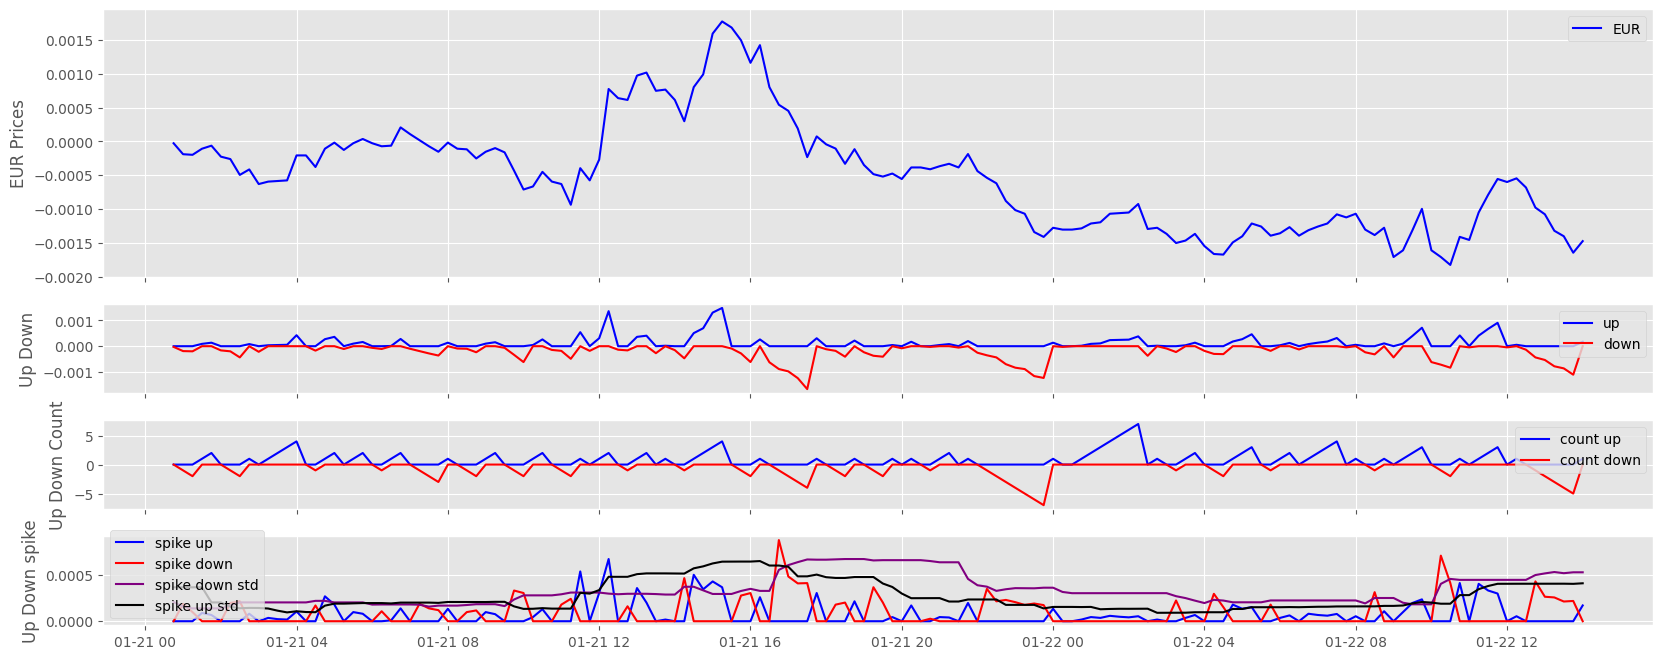

In [264]:
plot_up_down(df,1250,1400)
